# SM00: SageMaker and Production Pipelines

There are a lot of considerations in moving from a local model used to train and predict on batch data to a production model. This series of posts explores how to create an MLOps compliant production pipeline using AWS's SageMaker Studio.

SageMaker Studio is a suite of tools that helps manage the infrastructure and collaboration for a machine learning project in the AWS ecosystem. Some of the biggest advantages of SageMaker Studio include:

- Ability to spin up hardware resources as needed
- Automatically spin down hardware resources once the task is complete
- Ability to create a pipeline to automate the machine learning process from preprocessing data through deploying the model

## Prerequisites

For brevity, I'll assume that SageMaker Studio and an IAM role with the appropriate permissions have been set up. In a corporate/enterprise environment, these will generally be set up by an administrator or someone on the architecture team.

- For directions on setting up the SageMaker environment see [Onboard to Amazon SageMaker Domain Using Quick setup](https://docs.aws.amazon.com/sagemaker/latest/dg/onboard-quick-start.html)
- For directions on setting up an AWS account and IAM role see [Set Up Amazon SageMaker Prerequisites](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-set-up.html)

The notebooks in this series *may* run on a stand alone SageMaker Jupyter Notebook instance or *possibly* in a local environment where the AWS credentials are specified. However, this series is designed to take advantage of the managed infrastructure and other benefits of using SageMaker Studio, so that will be the prefered environment for all posts in the series. I won't be testing, trying, or troubleshooting the code to work on stand alone SageMaker Jupyter Notebook instances or local environments.

## Pipeline

Kevin Markham does a wonderful job of explaining a basic machine learning pipeline in his youtube video [How do I encode categorical featues using scikit-learn?](https://www.youtube.com/watch?v=irHhDMbw3xo). This pipeline (with a few additions) breaks down to the following diagram:

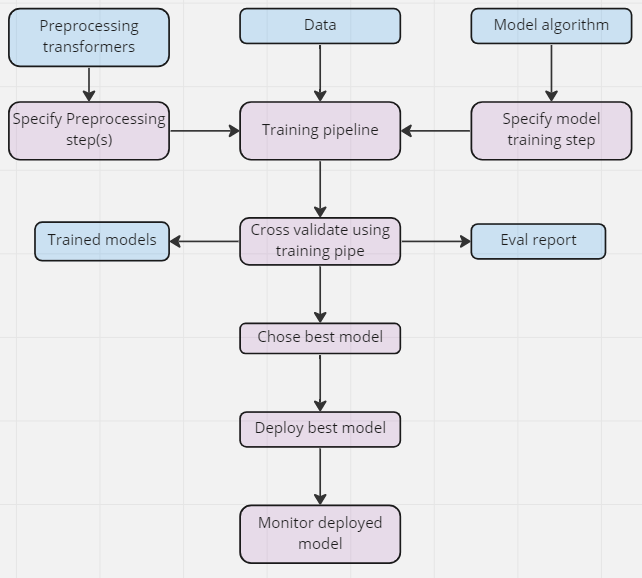

Other resources:

- [A Simple Guide to Scikit-learn Pipelines](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf)
- [6.1. Pipelines and composite estimators](https://scikit-learn.org/stable/modules/compose.html)
- [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)
- [Column Transformer with Mixed Types](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)

Implementing this in Sagemaker is a little more complicated than running the set of seven Jupyter Notebook cells that Kevin set up in his video. This is mainly due to the fact that the preprocessing step is completed (and the data saved) prior to running the model.

What this means is that the preprocessing can't be applied to just the training set (remember, the holdout subset changes across each fold specified for cross validation. For a refresher on cross validation, see [Entry 18: Cross-validation](https://julielinx.github.io/blog/18_crossval/).)

It may not seem like a big deal to apply your preprocessing to all your data at once, and it may make no difference to the predictions. However, there is a chance that it could cause data leakage, compromising the validity of your accuracy metrics. Any preprocessing that standardizes/normalizes or encodes a feature is suceptible to this kind of data leakage.

Let's take one hot encoding as an example. If the data has five categories overall - apples, oranges, strawberries, bananas, grapes - if the feature is encoded prior to splitting, then all five categories are guaranteed to be included. However, if subset of the data only includes three categories - apples, oranges, strawberries - it will still include all five categories if it has been pre-encoded.

The point of splitting the data into subsets is to replicate an enviornment where the model will encounter the same kinds of situations it would once deployed into production. If there are only three categories in the training subset, we only want those three categories to be predicted on. These types of situations are common in real world situations. Outlier numbers (example: values for a specific feature are usually 1-2, but sometimes a value of 10 or greater occurs) and new or missing categories (such as our example of 3 of 5 fruit types showing up) are (or should be) the expected behavior when taking in new observations.

My proposed solution to convert this to Sagemaker follows the below diagram:
    
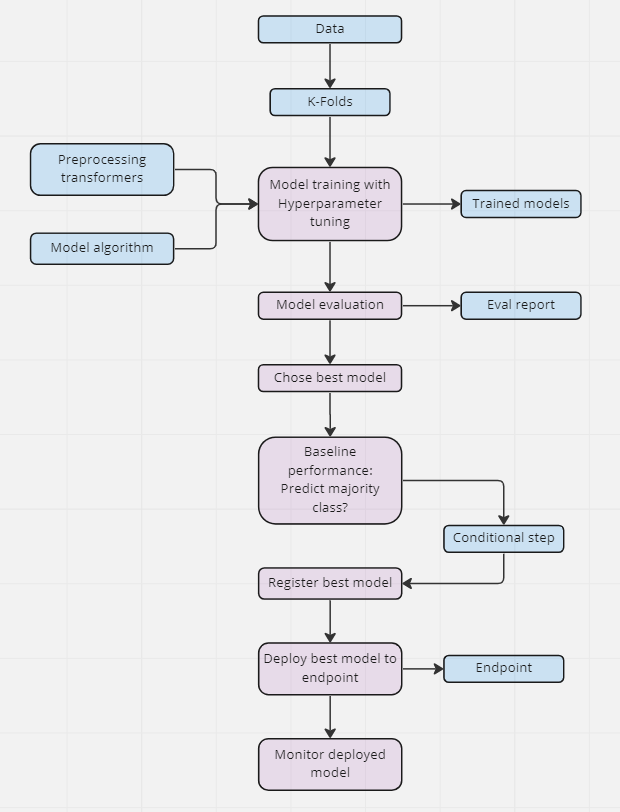

My main question at the moment is how to incorporate both cross validation and hyperparameter tuning. The Medium article [Cross-Validation and Hyperparameter Tuning: How to Optimise your Machine Learning Model](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d) uses `RandomizedSearchCV` from the `sklearn.model_selection` module. This has random grid search type hyperparameter tuning and cross validation bundled into the same function.

I see three methods of accomplishing incorporating both cross validation and hyperparameter tuning:

1. Bundle preprocessing, cross validation, hyperparameter tuning, and model training together into the same Sagemaker step and just use `sklearn`
1. Save the indices for `K` K-folds and preprocess the data as part of the model training
1. Split the data into the desired number of K-folds, preprocess each K-fold separately (ensuring to split out training and test datasets), save each train/test fold to S3, and train modesl on each of the folds

Option 1 negates the benefits of scaling and parallel processing that's available in Sagemaker. By bundling it all into the same step, every model trained in the cross validation process and for hyperparameter tuning would be trained on the same EC2 instance in sequence.

Option 2 provides the flexibility of spining up different instances to train each of the K-folds. This means I can train as many models for cross validation as I please, only relegating hyperparameter tuning to a single instance, which would be necessary anyway. The main drawback of this method is that the instance would have to apply preprocessing to it's specific K-fold of training data prior to training. This may or may not be a blocker.

Option 3 has the benefits of option 2 and also completes preprocessing prior to the model training attempt. The main drawback of this method is that I'd be storing `K` copies of the same data. While the underlying observations would be the same, the preprocessing would have been applied to different subsets of those observations. This may or may not result in different preprocessing parameters. The main benefit of this method over Option 2 is that if I want to train multiple algorithms (XGBoost, Logestic regressing, RandomForest, etc) I won't have to apply the same preprocessing over and over, the preprocessing will have already been applied and the folds of data will already be organized into subsets.

Another drawback to Option 3 is that the hyperparameters of trained `K` models could all be different, making it more difficult to determine how the "same" model (including the hyperparameters) perform on different subsets of data. This could be accounted for by repeating cross validation with models trained with the hyperparameters of the "best" model. Or even by completing cross validation with each of the `K` hyperparameters produced.

Other resources that discuss incorporating cross validation and hyperparameter tuning:

- [Cross validation and hyperparameter tuning workflow](https://stats.stackexchange.com/questions/553658/cross-validation-and-hyperparameter-tuning-workflow)
- [Cross-validation and hyperparameter tuning](https://www.datasciencecentral.com/model-evaluation-model-selection-and-algorithm-selection-in/): includes a diagram that is basically the same thing as Option 3
- [Training modes and algorithm support](https://docs.amazonaws.cn/en_us/sagemaker/latest/dg/autopilot-model-support-validation.html): hyperparameter tuning in Autoplot
- [Build a Highly Scalable Cross Validation Training Pipeline With Sagemaker](https://github.com/aws-samples/sagemaker-cross-validation-pipeline): github example that implements hyperparameter tuning with cross validation
- [Field Notes: Build a Cross-Validation Machine Learning Model Pipeline at Scale with Amazon SageMaker](https://aws.amazon.com/blogs/architecture/field-notes-build-a-cross-validation-machine-learning-model-pipeline-at-scale-with-amazon-sagemaker/): another example that implements hyperparameter tuning with cross validation
- [List of AWS built in Supervised Learning algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html#algorithms-built-in-supervised-learning)
- [CreateHyperParameterTuningJob syntax and parameters](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateHyperParameterTuningJob.html)
- [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html)

### Other thoughts

Hyperparameter tuning can take a significant amount of time, especially as the dataset becomes larger. I may want to consider tuning the hyperparameters on a subset of the training data, limiting the number of iterations, or establishing hyperparameters then performing cross validation on that particular set of hyperparameters.

## Series Guide

1. [Read from and Write to S3]()
1. [Clean Data]()
1. [ETL Pipe Foundations]()
1. [ETL (extract, transform, load) Script]()
1. [ETL Pipeline]()
1. [EDA (Exploratory Data Analysis)]()
1. [Develop Preprocessing Code]()
1. [Preprocessing Pipeline]()
1. [Train Pre-built Model]()
1. [Train Custom Model]()
1. [Inference]()
1. [Multistep Pipeline]()
1. [Custom Transformers]()
1. [Custom Transformers at Inference]()
1. [Hyperparameter Optimization]()
1. [Evaluate Model]()
1. [Register and Deploy]()
1. [Debugger]()
1. [Interpretability and Bias]()

## Best Practices for Flexibility/Automation

Based on experience, we want to keep as much related code in the same place as possible. In the past, our code has spanned different applications, EC2s, repos, and just about everything else you can think of. This made it extremely difficult to track down what code needed to be updated when we needed to make a change.

Additionally, we want to consolidate where changes need to be made in the code. In the past, we had hard coded values into several steps of the code. In the current code, the goal is to put hard coded values (in this case, the column names) all in the same script. Should we need to make changes to the included columns, we only have to change the `preprocessing.py` script. *Note*, in our production workflow, the data capture pulls all data in the specified tables regardless of whether that column is expected in the `preprocessing.py` script or not.

To update the workflow:

- If a new table is available
    - Add the table to the features DAG
    - Add the columns to the `preprocessing.py` script
- If a column was added or removed:
    - Add or remove the column(s) in the `preprocessing.py` script

## Python Scripts

All Python scripts to be run on EC2s in a pipeline are in the `write_scripts.ipynb`. This means that any changes needed to the Python scripts can be done all at once in the same `ipynb` notebook. Simply run the notebook to update the `.py` scripts.

To write these scripts to their own file use the built-in Jupyter magic command `%%writefile filename.py`. Everything in the cell with that magic command will be written to a separate file. Different file types can be written by changing the file extension. Example `filename.py` vs `filename.txt`.